# Import(s)

In [1]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

# Data

In [2]:
SYMBOL = 'BTCUSDT'
csv_folder_path = f'data/csv/{SYMBOL}'

columns = [
    'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_Time', 'Quote_asset_volume', 'Number_of_trades',
    'Taker_buy_volume', 'Taker_buy_quote_volume', 'Ignore'
]

## Read from folder

In [3]:
df_list = []

for file in glob.glob(os.path.join(csv_folder_path, '*.csv')):
    df = pd.read_csv(file, header=None, names=columns)
    df_list.append(df)

len(df_list)

2644

In [4]:
df_list[0]

,Open_Time,Open,High,Low,Close,Volume,Close_Time,Quote_asset_volume,Number_of_trades,Taker_buy_volume,Taker_buy_quote_volume,Ignore
0,1580083200000,8614.39,8653.21,8614.39,8649.11,355.367735,1580083259999,3.068193e+06,3033,254.795216,2.199980e+06,0
1,1580083260000,8650.21,8660.41,8632.52,8646.65,187.124770,1580083319999,1.618461e+06,1490,129.451622,1.119894e+06,0
2,1580083320000,8647.04,8648.18,8630.00,8630.44,60.790717,1580083379999,5.252803e+05,561,20.373615,1.760289e+05,0
3,1580083380000,8630.44,8637.06,8623.23,8630.87,60.337448,1580083439999,5.206711e+05,493,23.445074,2.023103e+05,0
4,1580083440000,8631.60,8634.98,8625.85,8626.68,49.020889,1580083499999,4.231228e+05,322,23.161763,1.999394e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1580169300000,8912.29,8917.13,8911.24,8911.63,6.288130,1580169359999,5.605012e+04,131,2.360999,2.104584e+04,0
1436,1580169360000,8912.09,8920.00,8911.91,8912.73,15.390124,1580169419999,1.372101e+05,186,7.265983,6.478069e+04,0
1437,1580169420000,8912.89,8912.89,8905.64,8906.90,11.414352,1580169479999,1.016862e+05,175,3.307321,2.946399e+04,0
1438,1580169480000,8907.87,8913.51,8906.26,8910.48,16.591149,1580169539999,1.478072e+05,174,10.085882,8.985922e+04,0


In [5]:
full_df = pd.concat(df_list, ignore_index=True)
full_df.shape

(3798962, 12)

In [6]:
full_df['Open_Time'].isna().unique(), full_df['Close_Time'].isna().unique()

(array([False]), array([False]))

In [7]:
full_df['Open_Time'].min(), full_df['Open_Time'].max()

(np.int64(1514764800000), np.int64(1743206340000000))

In [8]:
# # is not vectorized, meaning it's slow.
# for col in ['Open_Time', 'Close_Time']:
#     full_df[col] = full_df[col].apply(
#         lambda x:    pd.to_datetime(x, unit='ms') if 12 < np.log10(x) < 13
#                 else pd.to_datetime(x, unit='us') if 15 < np.log10(x) < 16
#                 else pd.NaT
#     )

## Datetime handling

In [9]:
# pre-compute the unit for all rows at once using np.log10, 
# then do two vectorized conversions with pd.to_datetime()
def handle_datetime_column(series):
    log_series  = np.log10(series)

    # Create masks
    ms_mask = (log_series > 12) & (log_series < 13)
    us_mask = (log_series > 15) & (log_series < 16)

    # Initialize empty datetime series
    converted = pd.Series(index=series.index, dtype='datetime64[ns]')

    # Vectorized datetime conversion
    converted[ms_mask] = pd.to_datetime(series[ms_mask], unit='ms', errors='coerce')
    converted[us_mask] = pd.to_datetime(series[us_mask], unit='us', errors='coerce')

    return converted


In [10]:
for col in ['Open_Time', 'Close_Time']:
    full_df[col] = handle_datetime_column(full_df[col])

# Optionally drop rows that failed conversion
# full_df.dropna(subset=['Open_Time', 'Close_Time'], inplace=True)

In [11]:
full_df

,Open_Time,Open,High,Low,Close,Volume,Close_Time,Quote_asset_volume,Number_of_trades,Taker_buy_volume,Taker_buy_quote_volume,Ignore
0,2020-01-27 00:00:00,8614.39,8653.21,8614.39,8649.11,355.367735,2020-01-27 00:00:59.999,3.068193e+06,3033,254.795216,2.199980e+06,0
1,2020-01-27 00:01:00,8650.21,8660.41,8632.52,8646.65,187.124770,2020-01-27 00:01:59.999,1.618461e+06,1490,129.451622,1.119894e+06,0
2,2020-01-27 00:02:00,8647.04,8648.18,8630.00,8630.44,60.790717,2020-01-27 00:02:59.999,5.252803e+05,561,20.373615,1.760289e+05,0
3,2020-01-27 00:03:00,8630.44,8637.06,8623.23,8630.87,60.337448,2020-01-27 00:03:59.999,5.206711e+05,493,23.445074,2.023103e+05,0
4,2020-01-27 00:04:00,8631.60,8634.98,8625.85,8626.68,49.020889,2020-01-27 00:04:59.999,4.231228e+05,322,23.161763,1.999394e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3798957,2022-04-04 23:55:00,46608.49,46610.00,46577.00,46587.49,11.259250,2022-04-04 23:55:59.999,5.246122e+05,450,3.601530,1.678028e+05,0
3798958,2022-04-04 23:56:00,46587.49,46603.17,46585.85,46603.17,6.705710,2022-04-04 23:56:59.999,3.124655e+05,440,3.795890,1.768704e+05,0
3798959,2022-04-04 23:57:00,46603.17,46611.77,46603.00,46608.53,12.411520,2022-04-04 23:57:59.999,5.784932e+05,568,6.999000,3.262153e+05,0
3798960,2022-04-04 23:58:00,46608.54,46620.57,46605.00,46610.62,15.729080,2022-04-04 23:58:59.999,7.332037e+05,524,7.580390,3.533453e+05,0


In [12]:
full_df['Open_Time'].isna().value_counts(), full_df['Close_Time'].isna().value_counts()

(Open_Time
 False    3798962
 Name: count, dtype: int64,
 Close_Time
 False    3798962
 Name: count, dtype: int64)

In [13]:
full_df['Open_Time'].min(), full_df['Open_Time'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2025-03-28 23:59:00'))

## Plot - 'Close' w.r.t 'Close_Time'

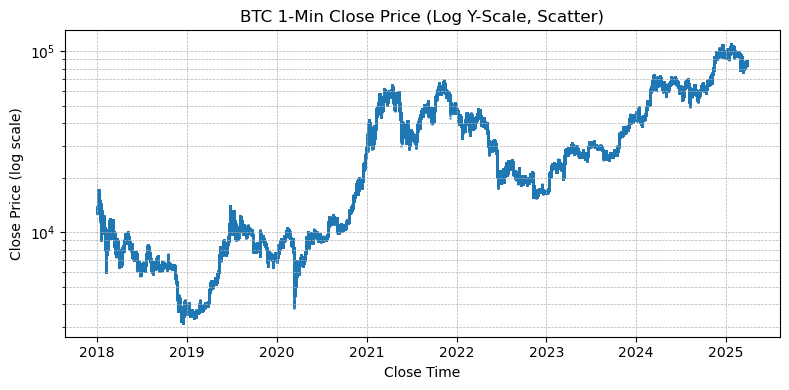

In [14]:
plt.figure(figsize=(8, 4))
plt.scatter(full_df['Close_Time'], full_df['Close'], s=1, alpha=0.6)  # s=1 for small dot size
plt.yscale('log')
plt.title('BTC 1-Min Close Price (Log Y-Scale, Scatter)')
plt.xlabel('Close Time')
plt.ylabel('Close Price (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Data Preprocessing
- Log-transform + Z-score

In [15]:
df_processed = full_df[['Close_Time', 'Close']].copy()
df_processed

,Close_Time,Close
0,2020-01-27 00:00:59.999,8649.11
1,2020-01-27 00:01:59.999,8646.65
2,2020-01-27 00:02:59.999,8630.44
3,2020-01-27 00:03:59.999,8630.87
4,2020-01-27 00:04:59.999,8626.68
...,...,...
3798957,2022-04-04 23:55:59.999,46587.49
3798958,2022-04-04 23:56:59.999,46603.17
3798959,2022-04-04 23:57:59.999,46608.53
3798960,2022-04-04 23:58:59.999,46610.62


In [16]:
df_processed['Close'].dtype

dtype('float64')

## Log-Transform

In [17]:
df_processed['Log_Close'] = np.log(df_processed['Close'])

## Z-Score

In [18]:
df_processed['Log_Close_Z'] = zscore(df_processed['Log_Close'])

In [19]:
df_processed

,Close_Time,Close,Log_Close,Log_Close_Z
0,2020-01-27 00:00:59.999,8649.11,9.065212,-0.954394
1,2020-01-27 00:01:59.999,8646.65,9.064927,-0.954704
2,2020-01-27 00:02:59.999,8630.44,9.063051,-0.956752
3,2020-01-27 00:03:59.999,8630.87,9.063101,-0.956697
4,2020-01-27 00:04:59.999,8626.68,9.062615,-0.957227
...,...,...,...,...
3798957,2022-04-04 23:55:59.999,46587.49,10.749087,0.882960
3798958,2022-04-04 23:56:59.999,46603.17,10.749424,0.883328
3798959,2022-04-04 23:57:59.999,46608.53,10.749539,0.883453
3798960,2022-04-04 23:58:59.999,46610.62,10.749584,0.883502


## Plot - 'Log-Z Close Price' w.r.t 'Close_Time'

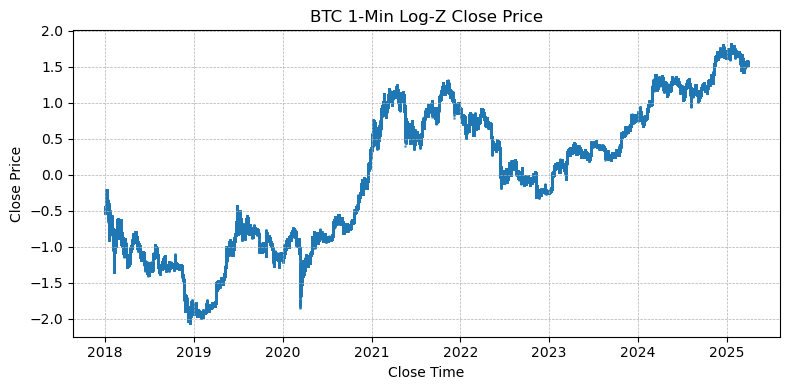

In [20]:
plt.figure(figsize=(8, 4))
plt.scatter(df_processed['Close_Time'], df_processed['Log_Close_Z'], s=1, alpha=0.6)  # s=1 for small dot size
# plt.yscale('log')
plt.title('BTC 1-Min Log-Z Close Price')
plt.xlabel('Close Time')
plt.ylabel('Close Price')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [21]:
df_final = df_processed[['Close_Time', 'Log_Close_Z']]
df_final

,Close_Time,Log_Close_Z
0,2020-01-27 00:00:59.999,-0.954394
1,2020-01-27 00:01:59.999,-0.954704
2,2020-01-27 00:02:59.999,-0.956752
3,2020-01-27 00:03:59.999,-0.956697
4,2020-01-27 00:04:59.999,-0.957227
...,...,...
3798957,2022-04-04 23:55:59.999,0.882960
3798958,2022-04-04 23:56:59.999,0.883328
3798959,2022-04-04 23:57:59.999,0.883453
3798960,2022-04-04 23:58:59.999,0.883502


# Subsequences

In [22]:
series = df_final['Log_Close_Z'].values

In [23]:
window_size = 20
stride = 5 

In [33]:
num_subsequences = (len(series) - window_size) // stride + 1

# Pre-allocate memory explicitly for efficiency (approx. 800,000 subsequences × window size 20 is about 80M floats ≈ 640MB)
subsequences = np.zeros((num_subsequences, window_size))#, dtype=np.float32)

all_indices = np.arange(num_subsequences) * stride           # [0, 5, 10, …]
subseq_times = df_final.index[all_indices] 

subseq_times

Index([      0,       5,      10,      15,      20,      25,      30,      35,
            40,      45,
       ...
       3798895, 3798900, 3798905, 3798910, 3798915, 3798920, 3798925, 3798930,
       3798935, 3798940],
      dtype='int64', length=759789)

In [34]:
for i in range(num_subsequences):
    start_idx = i * stride
    subsequences[i] = series[start_idx : start_idx + window_size]

In [35]:
subsequences_df = pd.DataFrame(subsequences)
subsequences_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.954394,-0.954704,-0.956752,-0.956697,-0.957227,-0.957060,-0.958041,-0.958381,-0.957991,-0.957006,-0.955382,-0.955246,-0.955890,-0.954803,-0.955550,-0.955244,-0.955354,-0.955544,-0.954661,-0.953935
1,-0.957060,-0.958041,-0.958381,-0.957991,-0.957006,-0.955382,-0.955246,-0.955890,-0.954803,-0.955550,-0.955244,-0.955354,-0.955544,-0.954661,-0.953935,-0.951374,-0.951471,-0.952173,-0.950401,-0.950437
2,-0.955382,-0.955246,-0.955890,-0.954803,-0.955550,-0.955244,-0.955354,-0.955544,-0.954661,-0.953935,-0.951374,-0.951471,-0.952173,-0.950401,-0.950437,-0.950275,-0.950526,-0.949422,-0.947932,-0.948519
3,-0.955244,-0.955354,-0.955544,-0.954661,-0.953935,-0.951374,-0.951471,-0.952173,-0.950401,-0.950437,-0.950275,-0.950526,-0.949422,-0.947932,-0.948519,-0.950060,-0.950343,-0.949662,-0.949902,-0.949657
4,-0.951374,-0.951471,-0.952173,-0.950401,-0.950437,-0.950275,-0.950526,-0.949422,-0.947932,-0.948519,-0.950060,-0.950343,-0.949662,-0.949902,-0.949657,-0.950501,-0.952095,-0.951965,-0.953452,-0.952285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759784,0.884730,0.884741,0.884817,0.884526,0.887262,0.887035,0.886376,0.888229,0.887469,0.886235,0.887618,0.888073,0.886708,0.884254,0.888667,0.889935,0.889204,0.887542,0.885357,0.885532
759785,0.887035,0.886376,0.888229,0.887469,0.886235,0.887618,0.888073,0.886708,0.884254,0.888667,0.889935,0.889204,0.887542,0.885357,0.885532,0.885472,0.884927,0.884905,0.884238,0.883994
759786,0.887618,0.888073,0.886708,0.884254,0.888667,0.889935,0.889204,0.887542,0.885357,0.885532,0.885472,0.884927,0.884905,0.884238,0.883994,0.884050,0.883801,0.882113,0.882859,0.882785
759787,0.889935,0.889204,0.887542,0.885357,0.885532,0.885472,0.884927,0.884905,0.884238,0.883994,0.884050,0.883801,0.882113,0.882859,0.882785,0.883043,0.882680,0.882346,0.883113,0.882779


In [36]:
subsequences_df.to_csv(f'data/subsequences/subseq_{SYMBOL}_ws={window_size}_stride={stride}.csv', index=False)

In [38]:
pd.Series(subseq_times).to_csv(f'data/subsequences/subseqtimes_{SYMBOL}_ws={window_size}_stride={stride}.csv', index=False)

In [39]:
subseq_times = subseq_times.to_numpy()

print(f"First 5 subsequence start times:\n{subseq_times[:5]}")
print(f"Total subsequences: {len(subseq_times)} (should match {num_subsequences})")

First 5 subsequence start times:
[ 0  5 10 15 20]
Total subsequences: 759789 (should match 759789)


In [40]:
df_final.to_csv(f'data/subsequences/df_final_{SYMBOL}_ws={window_size}_stride={stride}.csv', index=False)